**ADQUISICIÓN DE DATOS**

In [20]:
!pip install google-play-scraper pandas

In [ ]:
from google_play_scraper import reviews, Sort
import pandas as pd
import time

app_id = 'com.ubercab.eats'  # ID de Uber Eats

all_reviews = []
continuation_token = None

# Número total de reseñas y tamaño de lote
total_reviews = 50000
batch_size = 5000
num_batches = total_reviews // batch_size

for i in range(num_batches):
    print(f"Descargando lote {i+1} de {num_batches}...")

    result, continuation_token = reviews(
        app_id,
        lang='es',
        country='es',
        sort=Sort.NEWEST,
        count=batch_size,
        continuation_token=continuation_token
    )

    all_reviews.extend(result)

    time.sleep(5)  # Esperar 5 segundos entre lotes

# Guardar como CSV
df = pd.DataFrame(all_reviews)
df.to_csv('uber_eats_reviews.csv', index=False, encoding='utf-8')

print(f"Se descargaron {len(df)} reseñas.")

**PREPROCESAMIENTO DE DATOS**

In [1]:
!pip install spacy

In [3]:
import spacy.cli
spacy.cli.download("es_core_news_md")  



✔ Download and installation successful
You can now load the package via spacy.load('es_core_news_md')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.


In [5]:
import spacy
nlp = spacy.load("es_core_news_md")


In [7]:
!pip install nltk

In [1]:
!pip install wordcloud

In [3]:
import pandas as pd
import string
import re
import nltk
import spacy
import matplotlib.pyplot as plt
import gensim
import numpy as np


from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from wordcloud import WordCloud


nltk.download('punkt_tab')
nltk.download('stopwords')
nltk.download('wordnet')


[nltk_data] Downloading package punkt_tab to
[nltk_data]     C:\Users\mescr\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\mescr\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\mescr\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [5]:
nlp = spacy.load("es_core_news_sm")

In [7]:
reviews_df = pd.read_csv("uber_eats_reviews.csv")
reviews_df['content'] = reviews_df['content'].astype(str)
reviews_df.head()

,reviewId,userName,userImage,content,score,thumbsUpCount,reviewCreatedVersion,at,replyContent,repliedAt,appVersion
0,1755bf67-e676-46ba-ab84-0164e4204bc6,Un usuario de Google,https://play-lh.googleusercontent.com/EGemoI2N...,"no acepta tarjetas prepago además te cobran 0,...",1,0,6.265.10001,2025-04-15 11:54:08,NaN,NaN,6.265.10001
1,396555fc-fb74-405f-bc6b-709c9c65c370,Un usuario de Google,https://play-lh.googleusercontent.com/EGemoI2N...,inflan muchisimos los precios te cobran el env...,1,0,6.265.10001,2025-04-15 09:08:41,NaN,NaN,6.265.10001
2,02f55e3d-29e7-4225-b021-631dd52fcf69,Un usuario de Google,https://play-lh.googleusercontent.com/EGemoI2N...,era buena cuando daban cupones buenos habían p...,1,0,6.266.10000,2025-04-15 07:46:26,NaN,NaN,6.266.10000
3,6cba2823-ad2b-471c-bb19-10e2d4809668,Un usuario de Google,https://play-lh.googleusercontent.com/EGemoI2N...,kiero. explorarla,5,0,6.265.10001,2025-04-15 06:52:18,NaN,NaN,6.265.10001
4,41a56226-62ce-44c2-a9c9-ec1cf2ccf6ac,Un usuario de Google,https://play-lh.googleusercontent.com/EGemoI2N...,me estuve comunicando con un repartidor sobre ...,1,0,6.265.10001,2025-04-15 06:01:49,NaN,NaN,6.265.10001


In [9]:
print(reviews_df.describe())

              score  thumbsUpCount
count  50000.000000   50000.000000
mean       3.419340       0.946880
std        1.850049      12.855604
min        1.000000       0.000000
25%        1.000000       0.000000
50%        5.000000       0.000000
75%        5.000000       0.000000
max        5.000000     953.000000


In [11]:
print(reviews_df.isnull().sum())

reviewId                    0
userName                    0
userImage                   0
content                     0
score                       0
thumbsUpCount               0
reviewCreatedVersion     6849
at                          0
replyContent            49891
repliedAt               49891
appVersion               6849
dtype: int64


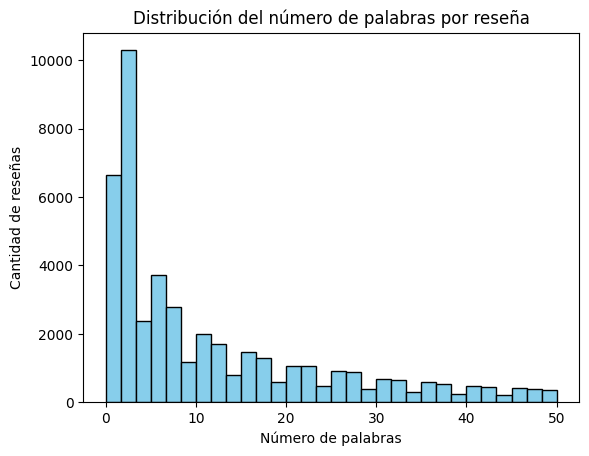

In [13]:
plt.hist(
    reviews_df['content'].apply(lambda x: len(str(x).split())),
    bins=30,
    color='skyblue',
    edgecolor='black',
    range=(0, 50)  
)
plt.title('Distribución del número de palabras por reseña')
plt.xlabel('Número de palabras')
plt.ylabel('Cantidad de reseñas')
plt.show()



In [15]:
columns_to_drop = [
    'reviewId',
    'userName',
    'userImage',
    'thumbsUpCount',
    'reviewCreatedVersion',
    'replyContent',
    'repliedAt'
]


reviews_df = reviews_df.drop(columns=columns_to_drop)


reviews_df.head()

,content,score,at,appVersion
0,"no acepta tarjetas prepago además te cobran 0,...",1,2025-04-15 11:54:08,6.265.10001
1,inflan muchisimos los precios te cobran el env...,1,2025-04-15 09:08:41,6.265.10001
2,era buena cuando daban cupones buenos habían p...,1,2025-04-15 07:46:26,6.266.10000
3,kiero. explorarla,5,2025-04-15 06:52:18,6.265.10001
4,me estuve comunicando con un repartidor sobre ...,1,2025-04-15 06:01:49,6.265.10001


In [17]:
import unicodedata

def normalize_text(text):
    # Remove numbers
    text = re.sub(r'\d+', '', text)

    # Remove punctuation and special characters
    text = text.translate(str.maketrans('', '', string.punctuation))

    # Remove emojis and specific Unicode characters
    emoji_pattern = re.compile(
        "["
        u"\U0001F600-\U0001F64F"  # Emoticons
        u"\U0001F300-\U0001F5FF"  # Symbols & Pictographs
        u"\U0001F680-\U0001F6FF"  # Transport & Map Symbols
        u"\U0001F1E0-\U0001F1FF"  # Flags (iOS)
        u"\U00002500-\U00002BEF"  # Chinese characters
        u"\U00002702-\U000027B0"
        u"\U000024C2-\U0001F251"
        u"\U0001Faaa"               # Specific Unicode (example)
        u"\u200d"                   # Zero-width joiner
        "]+", flags=re.UNICODE)
    text = emoji_pattern.sub(r'', text)

    # Remove accents
    text = unicodedata.normalize('NFD', text).encode('ascii', 'ignore').decode('utf-8')

    # Convert to lowercase
    text = text.lower()

    return text

# Eliminar duplicados por contenido
reviews_df = reviews_df.drop_duplicates(subset=['content'])

# Normalizar texto
reviews_df['normalized_review'] = reviews_df['content'].apply(normalize_text)


reviews_df.head()

,content,score,at,appVersion,normalized_review
0,"no acepta tarjetas prepago además te cobran 0,...",1,2025-04-15 11:54:08,6.265.10001,no acepta tarjetas prepago ademas te cobran p...
1,inflan muchisimos los precios te cobran el env...,1,2025-04-15 09:08:41,6.265.10001,inflan muchisimos los precios te cobran el env...
2,era buena cuando daban cupones buenos habían p...,1,2025-04-15 07:46:26,6.266.10000,era buena cuando daban cupones buenos habian p...
3,kiero. explorarla,5,2025-04-15 06:52:18,6.265.10001,kiero explorarla
4,me estuve comunicando con un repartidor sobre ...,1,2025-04-15 06:01:49,6.265.10001,me estuve comunicando con un repartidor sobre ...


In [19]:
# Tokenization
def tokenize_text(text):
    tokens = word_tokenize(text, language='spanish', preserve_line=True)
    return tokens

reviews_df['tokenized_review'] = reviews_df['normalized_review'].apply(tokenize_text)
reviews_df.head()

,content,score,at,appVersion,normalized_review,tokenized_review
0,"no acepta tarjetas prepago además te cobran 0,...",1,2025-04-15 11:54:08,6.265.10001,no acepta tarjetas prepago ademas te cobran p...,"[no, acepta, tarjetas, prepago, ademas, te, co..."
1,inflan muchisimos los precios te cobran el env...,1,2025-04-15 09:08:41,6.265.10001,inflan muchisimos los precios te cobran el env...,"[inflan, muchisimos, los, precios, te, cobran,..."
2,era buena cuando daban cupones buenos habían p...,1,2025-04-15 07:46:26,6.266.10000,era buena cuando daban cupones buenos habian p...,"[era, buena, cuando, daban, cupones, buenos, h..."
3,kiero. explorarla,5,2025-04-15 06:52:18,6.265.10001,kiero explorarla,"[kiero, explorarla]"
4,me estuve comunicando con un repartidor sobre ...,1,2025-04-15 06:01:49,6.265.10001,me estuve comunicando con un repartidor sobre ...,"[me, estuve, comunicando, con, un, repartidor,..."


In [21]:
# Remove Stopwords
stop_words = set(stopwords.words('spanish'))

custom_stopwords = ['vario', 'algun','meno','cada','tambien','siquiera', 'casi','mismo','asi', 'one','adema','aun','despues','varios','la','los','para','del','cuando','porque','que','por','con','una','uno','así','unos','la','estar','tener','haber','hacer','ello','más','el','mas','él','solo','habia','uber','Uber','eats','app','aplicación','aplicacion']
stop_words.update(custom_stopwords)

def remove_stopwords(tokens):
    # single characters
    filtered_tokens = [
        word for word in tokens
        if word not in stop_words and len(word) > 2 and word not in string.punctuation
    ]
    return filtered_tokens



In [23]:
# Apply stopword removal and special character filtering
reviews_df['no_stopwords_review'] = reviews_df['tokenized_review'].apply(remove_stopwords)

# Display the first few rows
reviews_df.head()

,content,score,at,appVersion,normalized_review,tokenized_review,no_stopwords_review
0,"no acepta tarjetas prepago además te cobran 0,...",1,2025-04-15 11:54:08,6.265.10001,no acepta tarjetas prepago ademas te cobran p...,"[no, acepta, tarjetas, prepago, ademas, te, co...","[acepta, tarjetas, prepago, ademas, cobran, co..."
1,inflan muchisimos los precios te cobran el env...,1,2025-04-15 09:08:41,6.265.10001,inflan muchisimos los precios te cobran el env...,"[inflan, muchisimos, los, precios, te, cobran,...","[inflan, muchisimos, precios, cobran, envio, g..."
2,era buena cuando daban cupones buenos habían p...,1,2025-04-15 07:46:26,6.266.10000,era buena cuando daban cupones buenos habian p...,"[era, buena, cuando, daban, cupones, buenos, h...","[buena, daban, cupones, buenos, habian, precio..."
3,kiero. explorarla,5,2025-04-15 06:52:18,6.265.10001,kiero explorarla,"[kiero, explorarla]","[kiero, explorarla]"
4,me estuve comunicando con un repartidor sobre ...,1,2025-04-15 06:01:49,6.265.10001,me estuve comunicando con un repartidor sobre ...,"[me, estuve, comunicando, con, un, repartidor,...","[comunicando, repartidor, problema, cambiar, d..."


In [25]:
# Lemmatization
def lemmatize_spacy(text):
    doc = nlp(' '.join(text))
    lemmatized_tokens = [token.lemma_ for token in doc]
    return lemmatized_tokens

reviews_df['lemmatized_review'] = reviews_df['no_stopwords_review'].apply(lemmatize_spacy)

reviews_df.head()

,content,score,at,appVersion,normalized_review,tokenized_review,no_stopwords_review,lemmatized_review
0,"no acepta tarjetas prepago además te cobran 0,...",1,2025-04-15 11:54:08,6.265.10001,no acepta tarjetas prepago ademas te cobran p...,"[no, acepta, tarjetas, prepago, ademas, te, co...","[acepta, tarjetas, prepago, ademas, cobran, co...","[aceptar, tarjeta, prepago, adema, cobrar, com..."
1,inflan muchisimos los precios te cobran el env...,1,2025-04-15 09:08:41,6.265.10001,inflan muchisimos los precios te cobran el env...,"[inflan, muchisimos, los, precios, te, cobran,...","[inflan, muchisimos, precios, cobran, envio, g...","[inflar, muchisir, precio, cobrar, envio, gast..."
2,era buena cuando daban cupones buenos habían p...,1,2025-04-15 07:46:26,6.266.10000,era buena cuando daban cupones buenos habian p...,"[era, buena, cuando, daban, cupones, buenos, h...","[buena, daban, cupones, buenos, habian, precio...","[buen, dar, cupón, buen, habiar, precio, bajo,..."
3,kiero. explorarla,5,2025-04-15 06:52:18,6.265.10001,kiero explorarla,"[kiero, explorarla]","[kiero, explorarla]","[kiero, explorar él]"
4,me estuve comunicando con un repartidor sobre ...,1,2025-04-15 06:01:49,6.265.10001,me estuve comunicando con un repartidor sobre ...,"[me, estuve, comunicando, con, un, repartidor,...","[comunicando, repartidor, problema, cambiar, d...","[comunicar, repartidor, problema, cambiar, dir..."


In [27]:
# Lemmatization using spaCy with multiple custom corrections and filtering out empty lists
def lemmatize_spacy_with_corrections(text):
    custom_corrections = {
        "aplicación": "app",
        "aplicaciones": "app",
        "apps": "app",
        "pedido": "pedir",
        "pedidos": "pedir",
        "pido": "pedir",
        "pidió": "pedir",
        "pidieron": "pedir",
        "comida": "comer",
        "comidas": "comer",
        "cobraron": "cobrar",
        "cobran": "cobrar",
        "cobro": "cobrar",
        "cobrando": "cobrar",
        "pagaron": "pagar",
        "pagando": "pagar",
        "pagué": "pagar",
        "pago": "pagar",
        "pagos": "pagar",
        "cancelaron": "cancelar",
        "cancelado": "cancelar",
        "cancelé": "cancelar",
        "entrega": "entregar",
        "entregó": "entregar",
        "entregaron": "entregar",
        "entregado": "entregar",
        "reembolso": "reembolsar",
        "reembolsaron": "reembolsar",
        "reembolsado": "reembolsar",
        "repartidor": "reparto",
        "repartidores": "reparto",
        "repartidora": "reparto",
        "cobrado": "cobrar",
        "reparto": "repartir",
        "llego": "llegar",
        "tenia": "tener",
        "deberiar": "deber",
    }

    doc = nlp(' '.join(text))
    lemmatized_tokens = []

    for token in doc:
        if token.text in custom_corrections:
            lemmatized_tokens.append(custom_corrections[token.text])
        else:
            lemmatized_tokens.append(token.lemma_)

    # Return None or an empty string if the list is empty
    return lemmatized_tokens if lemmatized_tokens else None


# Apply lemmatization with corrections
reviews_df['lemmatized_review_custom'] = reviews_df['lemmatized_review'].apply(lemmatize_spacy_with_corrections)

# Remove rows with empty lists or None in 'lemmatized_review_custom'
reviews_df = reviews_df[
    reviews_df['lemmatized_review_custom'].notna() &
    reviews_df['lemmatized_review_custom'].astype(bool)
]

# Remove stopwords again if necessary
reviews_df['lemmatized_review_custom'] = reviews_df['lemmatized_review_custom'].apply(remove_stopwords)


reviews_df.head()



,content,score,at,appVersion,normalized_review,tokenized_review,no_stopwords_review,lemmatized_review,lemmatized_review_custom
0,"no acepta tarjetas prepago además te cobran 0,...",1,2025-04-15 11:54:08,6.265.10001,no acepta tarjetas prepago ademas te cobran p...,"[no, acepta, tarjetas, prepago, ademas, te, co...","[acepta, tarjetas, prepago, ademas, cobran, co...","[aceptar, tarjeta, prepago, adema, cobrar, com...","[aceptar, tarjeta, prepago, cobrar, comprobar,..."
1,inflan muchisimos los precios te cobran el env...,1,2025-04-15 09:08:41,6.265.10001,inflan muchisimos los precios te cobran el env...,"[inflan, muchisimos, los, precios, te, cobran,...","[inflan, muchisimos, precios, cobran, envio, g...","[inflar, muchisir, precio, cobrar, envio, gast...","[inflar, muchisir, precio, cobrar, envio, gast..."
2,era buena cuando daban cupones buenos habían p...,1,2025-04-15 07:46:26,6.266.10000,era buena cuando daban cupones buenos habian p...,"[era, buena, cuando, daban, cupones, buenos, h...","[buena, daban, cupones, buenos, habian, precio...","[buen, dar, cupón, buen, habiar, precio, bajo,...","[buen, dar, cupón, buen, habiar, precio, bajo,..."
3,kiero. explorarla,5,2025-04-15 06:52:18,6.265.10001,kiero explorarla,"[kiero, explorarla]","[kiero, explorarla]","[kiero, explorar él]","[kiero, explorar]"
4,me estuve comunicando con un repartidor sobre ...,1,2025-04-15 06:01:49,6.265.10001,me estuve comunicando con un repartidor sobre ...,"[me, estuve, comunicando, con, un, repartidor,...","[comunicando, repartidor, problema, cambiar, d...","[comunicar, repartidor, problema, cambiar, dir...","[comunicar, reparto, problema, cambiar, direcc..."


In [29]:
def remove_accents_from_list(word_list):
    return [
        unicodedata.normalize('NFD', word).encode('ascii', 'ignore').decode('utf-8')
        for word in word_list
    ]


reviews_df['lemmatized_review_custom'] = reviews_df['lemmatized_review_custom'].apply(remove_accents_from_list)


In [30]:
# Apply stopword removal and special character filtering
reviews_df['lemmatized_review_custom'] = reviews_df['lemmatized_review_custom'].apply(remove_stopwords)


reviews_df.head()

,content,score,at,appVersion,normalized_review,tokenized_review,no_stopwords_review,lemmatized_review,lemmatized_review_custom
0,"no acepta tarjetas prepago además te cobran 0,...",1,2025-04-15 11:54:08,6.265.10001,no acepta tarjetas prepago ademas te cobran p...,"[no, acepta, tarjetas, prepago, ademas, te, co...","[acepta, tarjetas, prepago, ademas, cobran, co...","[aceptar, tarjeta, prepago, adema, cobrar, com...","[aceptar, tarjeta, prepago, cobrar, comprobar,..."
1,inflan muchisimos los precios te cobran el env...,1,2025-04-15 09:08:41,6.265.10001,inflan muchisimos los precios te cobran el env...,"[inflan, muchisimos, los, precios, te, cobran,...","[inflan, muchisimos, precios, cobran, envio, g...","[inflar, muchisir, precio, cobrar, envio, gast...","[inflar, muchisir, precio, cobrar, envio, gast..."
2,era buena cuando daban cupones buenos habían p...,1,2025-04-15 07:46:26,6.266.10000,era buena cuando daban cupones buenos habian p...,"[era, buena, cuando, daban, cupones, buenos, h...","[buena, daban, cupones, buenos, habian, precio...","[buen, dar, cupón, buen, habiar, precio, bajo,...","[buen, dar, cupon, buen, habiar, precio, bajo,..."
3,kiero. explorarla,5,2025-04-15 06:52:18,6.265.10001,kiero explorarla,"[kiero, explorarla]","[kiero, explorarla]","[kiero, explorar él]","[kiero, explorar]"
4,me estuve comunicando con un repartidor sobre ...,1,2025-04-15 06:01:49,6.265.10001,me estuve comunicando con un repartidor sobre ...,"[me, estuve, comunicando, con, un, repartidor,...","[comunicando, repartidor, problema, cambiar, d...","[comunicar, repartidor, problema, cambiar, dir...","[comunicar, reparto, problema, cambiar, direcc..."


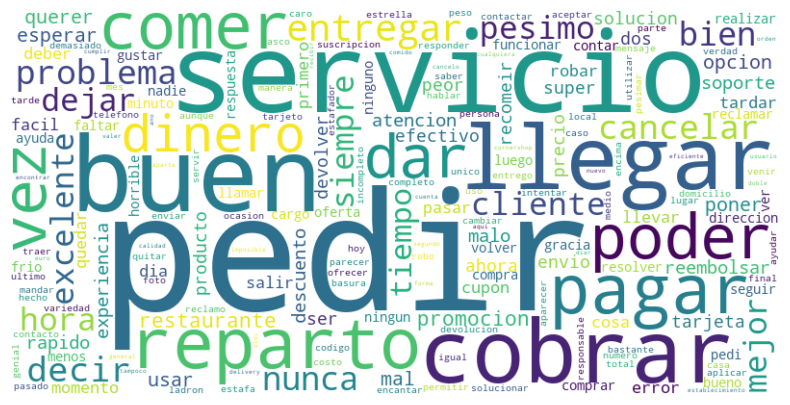

In [33]:
# word cloud generation
all_words = ' '.join([' '.join(review) for review in reviews_df['lemmatized_review_custom']])
wordcloud = WordCloud(width=800, height=400, background_color='white', collocations=False).generate(all_words)

plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')  # Turn off axis
plt.show()

**ANÁLISIS DESCRIPTIVO**

ANÁLISIS GRAMATICAL DE ADJETIVOS

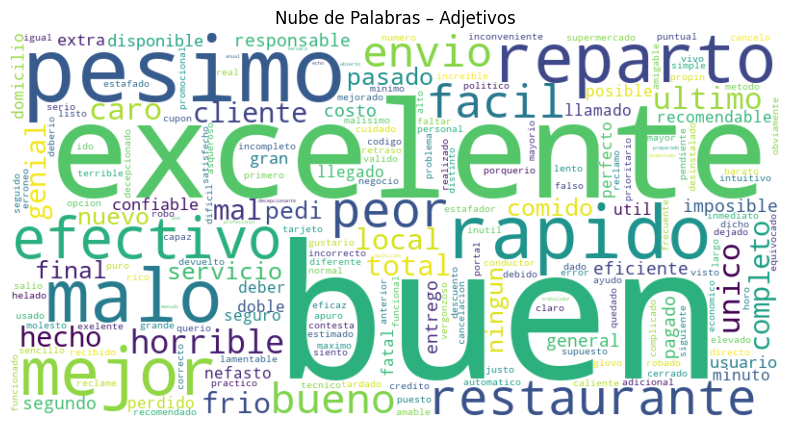

In [35]:
from collections import Counter


texts = [' '.join(tokens) for tokens in reviews_df['lemmatized_review_custom']]

docs = list(nlp.pipe(texts, batch_size=32))


df_POS = pd.DataFrame({'lemmatized_review_custom': texts})

df_POS['rule_based_pos'] = [[(token.text, token.pos_) for token in doc] for doc in docs]


# Extrae solo los adjetivos de cada fila

df_POS['adjectives'] = df_POS['rule_based_pos'].apply(

lambda tokens: [word for word, pos in tokens if pos == 'ADJ']

)


# Lista de todos los adjetivos del corpus

all_adjs = [adj for sublist in df_POS['adjectives'] for adj in sublist]


# Conteo de frecuencia

adj_freq = Counter(all_adjs)


# Generar la nube de palabras

wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(adj_freq)



plt.figure(figsize=(10, 5))

plt.imshow(wordcloud, interpolation='bilinear')

plt.axis('off')

plt.title("Nube de Palabras – Adjetivos")

plt.show()

In [37]:
adjective_counts = Counter(all_adjs)
most_common_adjectives = adjective_counts.most_common(10)
most_common_adjectives

[('buen', 5579),
 ('excelente', 2466),
 ('pesimo', 2463),
 ('malo', 1570),
 ('rapido', 1564),
 ('reparto', 1327),
 ('mejor', 1286),
 ('efectivo', 1190),
 ('restaurante', 1026),
 ('peor', 1008)]

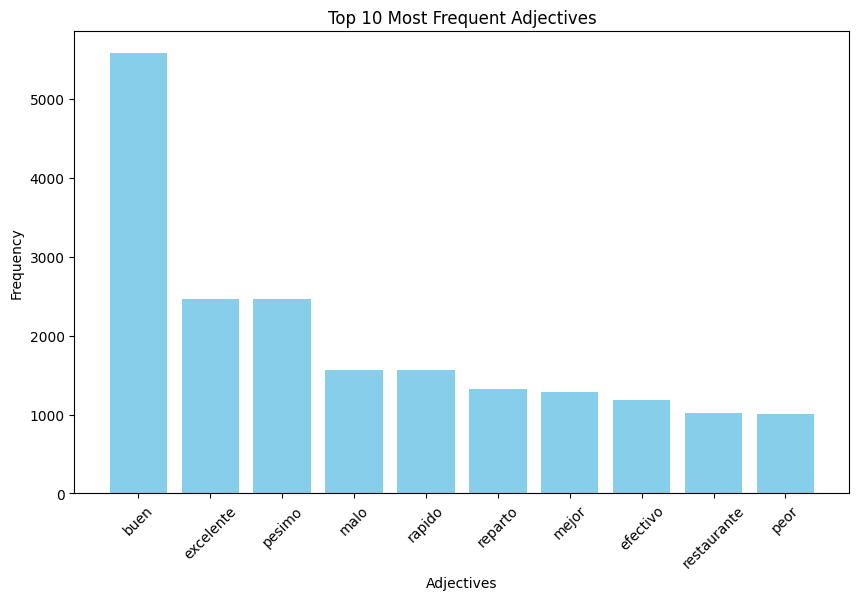

In [39]:
# Separate adjectives and frequencies
adjectives, counts = zip(*most_common_adjectives)


plt.figure(figsize=(10, 6))
plt.bar(adjectives, counts, color='skyblue')
plt.xlabel('Adjectives')
plt.ylabel('Frequency')
plt.title('Top 10 Most Frequent Adjectives')
plt.xticks(rotation=45)
plt.show()

TF-IDF

In [41]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

dft = [str(x) for x in reviews_df['lemmatized_review_custom'] if str(x) != 'nan']  # Convert each non-NaN entry in the 'lemmatized_review_custom' column to a string and store it in a list.
tfIdfVectorizer = TfidfVectorizer(use_idf=True)  # Initialize the TF-IDF vectorizer, enabling the use of the Inverse Document Frequency (IDF) weighting.
tfIdf = tfIdfVectorizer.fit_transform(dft)  # Fit the vectorizer to the data and transform the text into a sparse matrix of TF-IDF features.
names = tfIdfVectorizer.get_feature_names_out()  # Retrieve the feature names (i.e., the words) from the TF-IDF vectorizer.
freqs = tfIdf.sum(axis=0).A1  # Sum the TF-IDF scores for each word across all documents, resulting in the total TF-IDF score for each word.
result = dict(zip(names, freqs))  # Combine the feature names (words) and their corresponding TF-IDF scores into a dictionary.

# Mostrar solo las 20 palabras más relevantes ordenadas por score
top_n = 20
sorted_result = sorted(result.items(), key=lambda x: x[1], reverse=True)[:top_n]
for word, score in sorted_result:
    print(f"{word}: {score:.3f}")


pedir: 1830.495
buen: 1773.593
servicio: 1284.311
excelente: 1099.164
llegar: 823.089
bien: 807.236
cobrar: 776.760
comer: 767.191
mejor: 714.132
pagar: 688.919
reparto: 684.246
promocion: 636.215
rapido: 626.142
vez: 598.333
siempre: 596.854
entregar: 586.211
poder: 569.176
dar: 556.391
problema: 551.659
dinero: 520.927


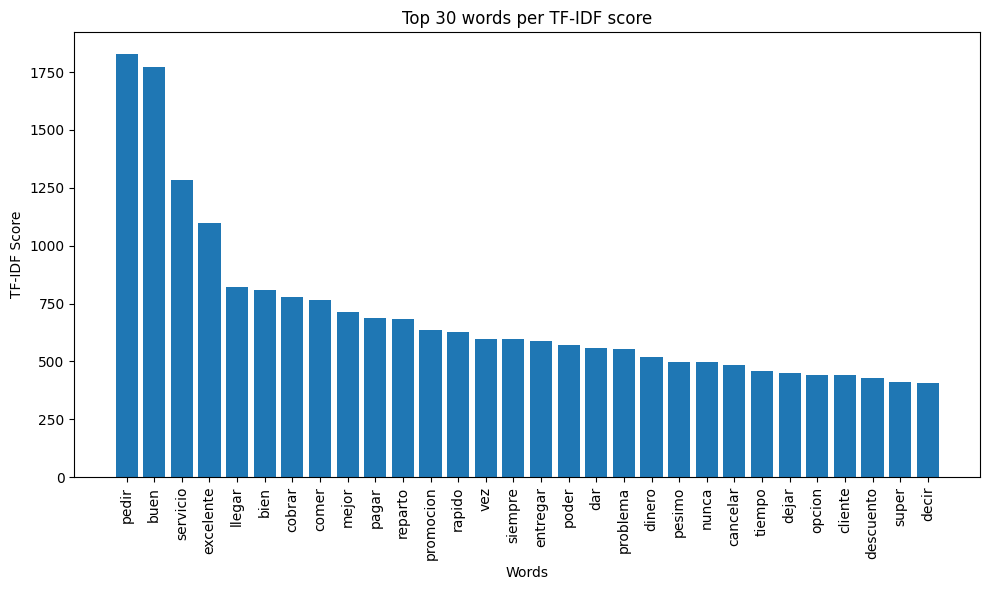

In [43]:
from operator import itemgetter

results_sorted = sorted(result.items(), key=itemgetter(1), reverse=True)  # Sort the dictionary 'result' (which contains words and their TF-IDF scores) by the TF-IDF scores in descending order.
top_words = results_sorted[:30]  # Select the top 30 words with the highest TF-IDF scores.
words, frequencies = zip(*top_words)  # Unpack the top words and their corresponding frequencies into two separate lists: 'words' and 'frequencies'.

plt.figure(figsize=(10, 6))
plt.bar(words, frequencies)
plt.xlabel('Words')
plt.ylabel('TF-IDF Score')
plt.title('Top 30 words per TF-IDF score')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

BIGRAMAS

In [46]:
tfIdfVectorizer_bi = TfidfVectorizer(use_idf = True, ngram_range = (2,2))
tfIdf_bi = tfIdfVectorizer_bi.fit_transform(dft)
names_bi = tfIdfVectorizer_bi.get_feature_names_out()
freqs_bi = tfIdf_bi.sum(axis=0).A1
result_bi = dict(zip(names_bi, freqs_bi))

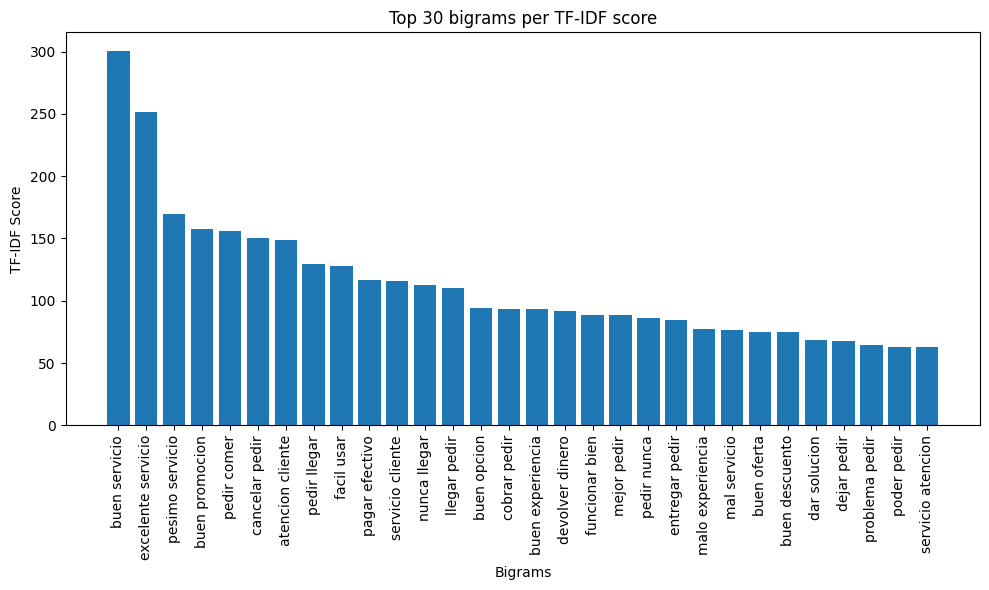

In [48]:
results_sorted_bi = sorted(result_bi.items(), key=itemgetter(1), reverse=True)
top_bi_words = results_sorted_bi[:30]
words_bi, frequencies_bi = zip(*top_bi_words)

plt.figure(figsize=(10, 6))
plt.bar(words_bi, frequencies_bi)
plt.xlabel('Bigrams')
plt.ylabel('TF-IDF Score')
plt.title('Top 30 bigrams per TF-IDF score')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

In [50]:
!pip install adjustText


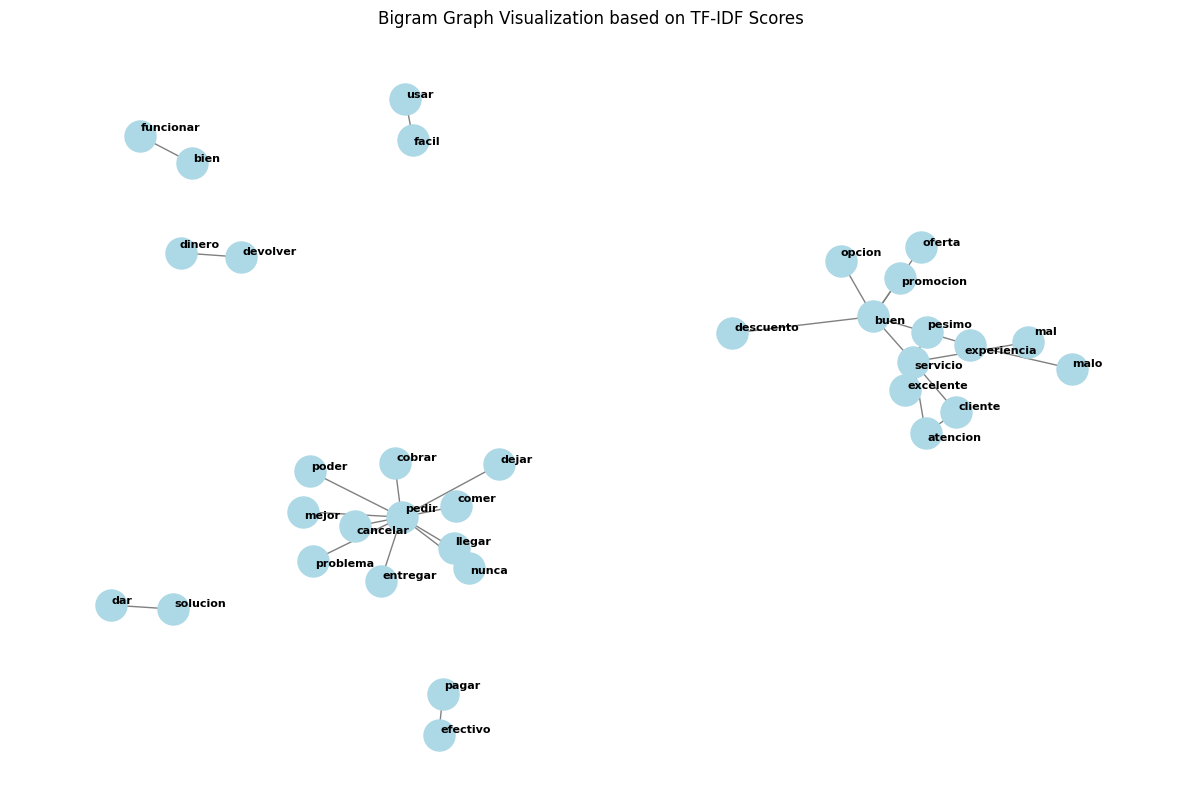

In [52]:
import networkx as nx
from adjustText import adjust_text

G = nx.Graph()

for bigram, score in top_bi_words:
    word1, word2 = bigram.split()
    G.add_edge(word1, word2, weight=score)

plt.figure(figsize=(15, 10))
pos = nx.spring_layout(G, k=1.2, seed=42)

nx.draw_networkx_nodes(G, pos, node_color='lightblue', node_size=500)
nx.draw_networkx_edges(G, pos, edge_color='gray')

texts = []
for node, (x, y) in pos.items():
    texts.append(plt.text(x, y, node, fontsize=8, fontweight='bold'))

adjust_text(texts, arrowprops=dict(arrowstyle='-', color='red'))

plt.title('Bigram Graph Visualization based on TF-IDF Scores')
plt.axis('off')
plt.savefig('bigram_graph.png', dpi=300, bbox_inches='tight')
plt.show()


TRIGRAMAS

In [55]:
tfIdfVectorizer_tri = TfidfVectorizer(use_idf = True, ngram_range = (3,3))
tfIdf_tri = tfIdfVectorizer_tri.fit_transform(dft)
names_tri = tfIdfVectorizer_tri.get_feature_names_out()
freqs_tri = tfIdf_tri.sum(axis=0).A1
result_tri = dict(zip(names_tri, freqs_tri))

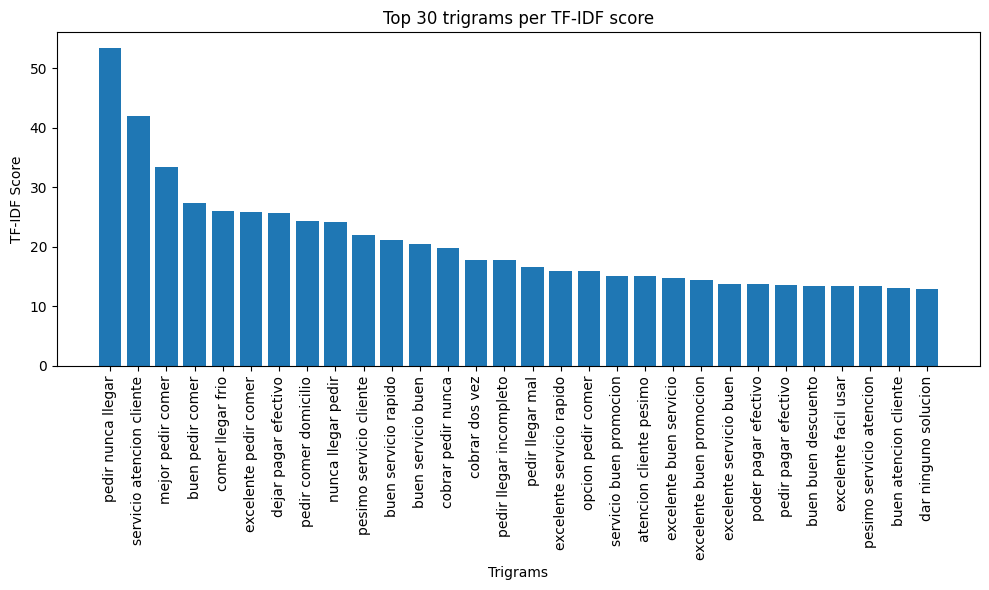

In [57]:
results_sorted_tri = sorted(result_tri.items(), key=itemgetter(1), reverse=True)
top_tri_words = results_sorted_tri[:30]
words_tri, frequencies_tri = zip(*top_tri_words)

plt.figure(figsize=(10, 6))
plt.bar(words_tri, frequencies_tri)
plt.xlabel('Trigrams')
plt.ylabel('TF-IDF Score')
plt.title('Top 30 trigrams per TF-IDF score')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

In [51]:
!pip install -q openpyxl

In [53]:
reviews_df.to_csv("reviews_preprocessed.csv", index=False, encoding="utf-8")


GENERACIÓN DE GRÁFICOS

In [59]:
reviewsclean_df = pd.read_csv("reviews_preprocessed.csv")

print(reviewsclean_df.shape)
reviewsclean_df.head()

(37499, 9)


,content,score,at,appVersion,normalized_review,tokenized_review,no_stopwords_review,lemmatized_review,lemmatized_review_custom
0,"no acepta tarjetas prepago además te cobran 0,...",1,2025-04-15 11:54:08,6.265.10001,no acepta tarjetas prepago ademas te cobran p...,"['no', 'acepta', 'tarjetas', 'prepago', 'adema...","['acepta', 'tarjetas', 'prepago', 'ademas', 'c...","['aceptar', 'tarjeta', 'prepago', 'adema', 'co...","['aceptar', 'tarjeta', 'prepago', 'cobrar', 'c..."
1,inflan muchisimos los precios te cobran el env...,1,2025-04-15 09:08:41,6.265.10001,inflan muchisimos los precios te cobran el env...,"['inflan', 'muchisimos', 'los', 'precios', 'te...","['inflan', 'muchisimos', 'precios', 'cobran', ...","['inflar', 'muchisir', 'precio', 'cobrar', 'en...","['inflar', 'muchisir', 'precio', 'cobrar', 'en..."
2,era buena cuando daban cupones buenos habían p...,1,2025-04-15 07:46:26,6.266.10000,era buena cuando daban cupones buenos habian p...,"['era', 'buena', 'cuando', 'daban', 'cupones',...","['buena', 'daban', 'cupones', 'buenos', 'habia...","['buen', 'dar', 'cupón', 'buen', 'habiar', 'pr...","['buen', 'dar', 'cupon', 'buen', 'habiar', 'pr..."
3,kiero. explorarla,5,2025-04-15 06:52:18,6.265.10001,kiero explorarla,"['kiero', 'explorarla']","['kiero', 'explorarla']","['kiero', 'explorar él']","['kiero', 'explorar']"
4,me estuve comunicando con un repartidor sobre ...,1,2025-04-15 06:01:49,6.265.10001,me estuve comunicando con un repartidor sobre ...,"['me', 'estuve', 'comunicando', 'con', 'un', '...","['comunicando', 'repartidor', 'problema', 'cam...","['comunicar', 'repartidor', 'problema', 'cambi...","['comunicar', 'reparto', 'problema', 'cambiar'..."


In [61]:
reviewsclean_df['at'] = pd.to_datetime(reviewsclean_df['at'], errors='coerce')


reviewsclean_df['day_of_the_week'] = reviewsclean_df['at'].dt.day_name()


dias_es = {
    'Monday': 'Lunes',
    'Tuesday': 'Martes',
    'Wednesday': 'Miércoles',
    'Thursday': 'Jueves',
    'Friday': 'Viernes',
    'Saturday': 'Sábado',
    'Sunday': 'Domingo'
}
reviewsclean_df['day_of_the_week'] = reviewsclean_df['day_of_the_week'].map(dias_es)


reviewsclean_df[['at', 'day_of_the_week']].head()


,at,day_of_the_week
0,2025-04-15 11:54:08,Martes
1,2025-04-15 09:08:41,Martes
2,2025-04-15 07:46:26,Martes
3,2025-04-15 06:52:18,Martes
4,2025-04-15 06:01:49,Martes


In [63]:
reviewsclean_df[['at', 'day_of_the_week']]


,at,day_of_the_week
0,2025-04-15 11:54:08,Martes
1,2025-04-15 09:08:41,Martes
2,2025-04-15 07:46:26,Martes
3,2025-04-15 06:52:18,Martes
4,2025-04-15 06:01:49,Martes
...,...,...
37494,2023-06-15 22:27:21,Jueves
37495,2023-06-15 22:07:04,Jueves
37496,2023-06-15 22:00:21,Jueves
37497,2023-06-15 21:52:06,Jueves


In [65]:
reviewsclean_df['at'] = pd.to_datetime(reviewsclean_df['at'], errors='coerce')


reviewsclean_df['hora'] = reviewsclean_df['at'].dt.hour

# Asignar franjas horarias según la hora
def asignar_franja(hora):
    if 7 <= hora < 11:
        return 'Desayuno'
    elif 11 <= hora < 13:
        return 'Almuerzo'
    elif 13 <= hora < 16:
        return 'Comida'
    elif 16 <= hora < 20:
        return 'Merienda'
    elif 20 <= hora < 24:
        return 'Cena'
    else:
        return 'Hora especial'  # de 00:00 a 06:59


reviewsclean_df['franja_horaria'] = reviewsclean_df['hora'].apply(asignar_franja)


reviewsclean_df[['at', 'franja_horaria']].head(10)

,at,franja_horaria
0,2025-04-15 11:54:08,Almuerzo
1,2025-04-15 09:08:41,Desayuno
2,2025-04-15 07:46:26,Desayuno
3,2025-04-15 06:52:18,Hora especial
4,2025-04-15 06:01:49,Hora especial
5,2025-04-15 05:38:49,Hora especial
6,2025-04-15 05:19:07,Hora especial
7,2025-04-15 04:42:05,Hora especial
8,2025-04-15 04:37:08,Hora especial
9,2025-04-15 04:29:03,Hora especial


In [67]:
reviewsclean_df[['at', 'franja_horaria']]


,at,franja_horaria
0,2025-04-15 11:54:08,Almuerzo
1,2025-04-15 09:08:41,Desayuno
2,2025-04-15 07:46:26,Desayuno
3,2025-04-15 06:52:18,Hora especial
4,2025-04-15 06:01:49,Hora especial
...,...,...
37494,2023-06-15 22:27:21,Cena
37495,2023-06-15 22:07:04,Cena
37496,2023-06-15 22:00:21,Cena
37497,2023-06-15 21:52:06,Cena


In [69]:
def agrupar_version(version):
    try:
        if pd.isna(version):  
            return "desconocida"
        
        partes = str(version).split('.')  
        
        # Validar que tiene al menos dos partes y que son numéricas
        if len(partes) >= 2 and partes[0].isdigit() and partes[1].isdigit():
            major = int(partes[0])
            minor = int(partes[1])
            return f"{major}.{minor}"
        else:
            return "desconocida"
    except:
        return "desconocida"


reviewsclean_df['appVersion_group'] = reviewsclean_df['appVersion'].apply(agrupar_version)


print(reviewsclean_df[['appVersion', 'appVersion_group']].head())





    appVersion appVersion_group
0  6.265.10001            6.265
1  6.265.10001            6.265
2  6.266.10000            6.266
3  6.265.10001            6.265
4  6.265.10001            6.265


In [71]:
# Asegurar que 'score' es numérico
reviewsclean_df['score'] = pd.to_numeric(reviewsclean_df['score'], errors='coerce')

# Asegurar que 'appVersion_group' es numérico (float)
reviewsclean_df['appVersion_group'] = pd.to_numeric(reviewsclean_df['appVersion_group'], errors='coerce')

# Eliminar filas con valores nulos
df_corr = reviewsclean_df.dropna(subset=['score', 'appVersion_group'])

# Calcular correlación de Pearson
correlacion = df_corr['score'].corr(df_corr['appVersion_group'])

print(f"Correlación entre 'score' y 'appVersion_group': {correlacion:.4f}")



Correlación entre 'score' y 'appVersion_group': 0.0548


In [73]:
reviewsclean_df['review_length'] = reviewsclean_df['content'].apply(len)
correlacion_longitud_score = reviewsclean_df[['score', 'review_length']].corr()
print("Correlación entre score y longitud de la reseña:")
print(correlacion_longitud_score)


Correlación entre score y longitud de la reseña:
                 score  review_length
score          1.00000       -0.53321
review_length -0.53321        1.00000


In [75]:

reviewsclean_df.groupby('day_of_the_week')['score'].mean().sort_values(ascending=False)


day_of_the_week
Domingo      3.060932
Sábado       2.991598
Jueves       2.962610
Lunes        2.930245
Viernes      2.912832
Martes       2.885086
Miércoles    2.843092
Name: score, dtype: float64

C:\Users\mescr\AppData\Local\Temp\ipykernel_13716\2155689617.py:7: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(


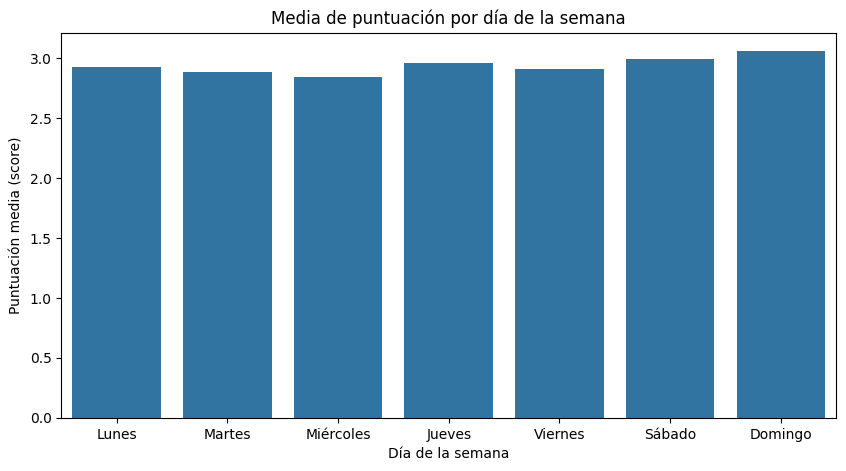

In [77]:
import seaborn as sns


dias_ordenados = ['Lunes', 'Martes', 'Miércoles', 'Jueves', 'Viernes', 'Sábado', 'Domingo']

plt.figure(figsize=(10,5))
sns.barplot(
    data=reviewsclean_df,
    x='day_of_the_week',
    y='score',
    order=dias_ordenados,
    ci=None
)
plt.title('Media de puntuación por día de la semana')
plt.xlabel('Día de la semana')
plt.ylabel('Puntuación media (score)')
plt.show()


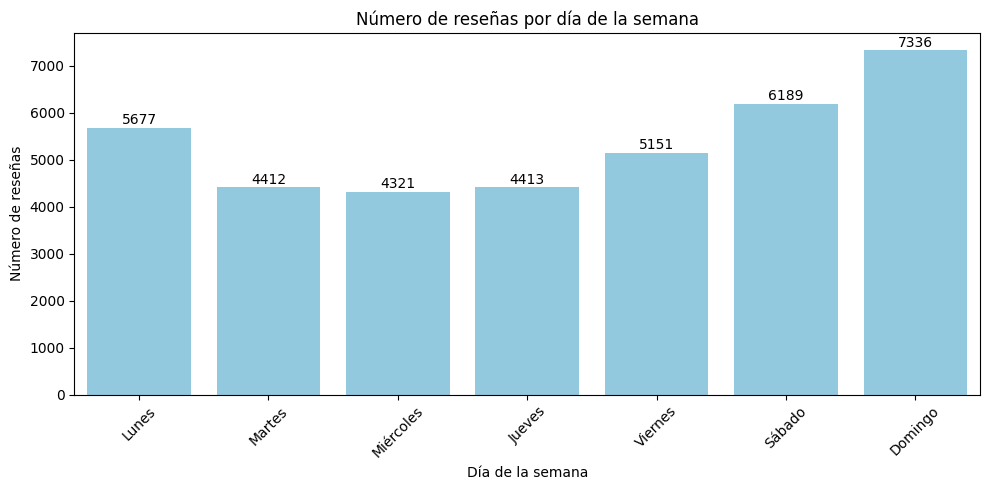

In [79]:
# Asegurar que la columna 'day_of_the_week' está creada
reviewsclean_df['day_of_the_week'] = pd.to_datetime(reviewsclean_df['at'], errors='coerce').dt.day_name()

# Contar pedidos por día de la semana y ordenar en orden lógico
dias_orden_ingles = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
dias_orden_espanol = ['Lunes', 'Martes', 'Miércoles', 'Jueves', 'Viernes', 'Sábado', 'Domingo']

pedido_counts = reviewsclean_df['day_of_the_week'].value_counts().reindex(dias_orden_ingles)


plt.figure(figsize=(10, 5))
sns.barplot(x=dias_orden_espanol, y=pedido_counts.values, color='skyblue')


for i, v in enumerate(pedido_counts.values):
    plt.text(i, v + 10, str(v), ha='center', va='bottom')

plt.title("Número de reseñas por día de la semana")
plt.xlabel("Día de la semana")
plt.ylabel("Número de reseñas")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


In [81]:
# Ver media de score por franja horaria
reviewsclean_df.groupby('franja_horaria')['score'].mean().sort_values(ascending=False)


franja_horaria
Hora especial    3.081177
Cena             3.012754
Merienda         3.001034
Comida           2.375349
Desayuno         2.198198
Almuerzo         1.935644
Name: score, dtype: float64

C:\Users\mescr\AppData\Local\Temp\ipykernel_13716\2623341546.py:5: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(


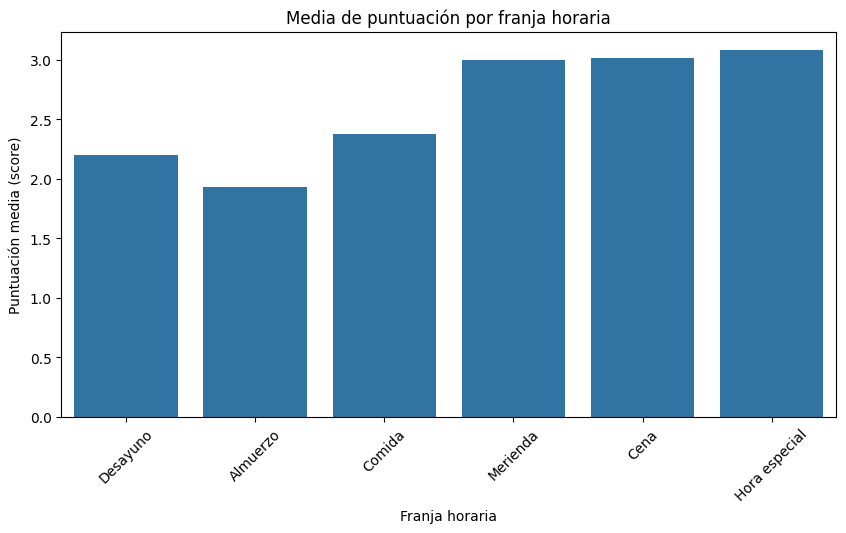

In [83]:
# Orden lógico de las franjas horarias
orden_franjas = ['Desayuno', 'Almuerzo', 'Comida', 'Merienda', 'Cena', 'Hora especial']

plt.figure(figsize=(10,5))
sns.barplot(
    data=reviewsclean_df,
    x='franja_horaria',
    y='score',
    order=orden_franjas,
    ci=None
)
plt.title('Media de puntuación por franja horaria')
plt.xlabel('Franja horaria')
plt.ylabel('Puntuación media (score)')
plt.xticks(rotation=45)
plt.show()


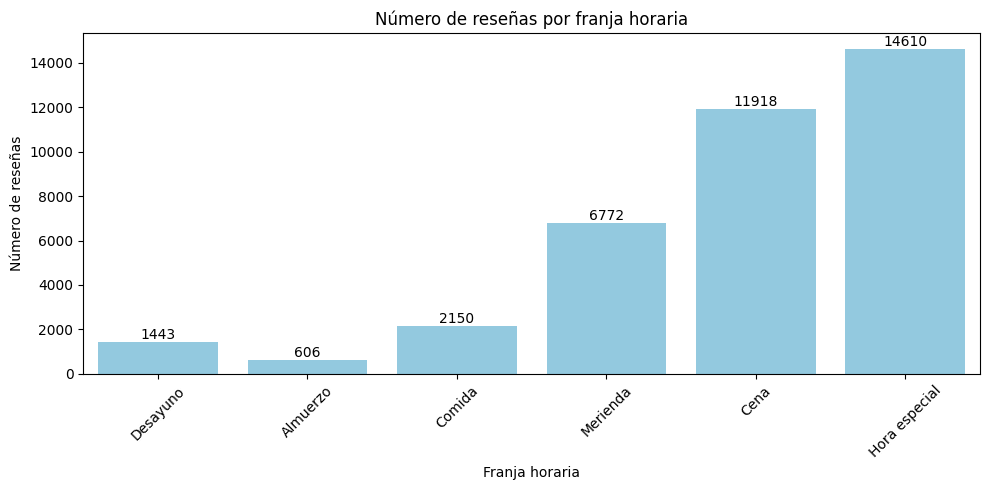

In [85]:
# Definir el orden deseado de las franjas horarias
orden_franjas = ['Desayuno', 'Almuerzo', 'Comida', 'Merienda', 'Cena', 'Hora especial']

# Contar reseñas por franja horaria y ordenar según el orden definido
franja_counts = reviewsclean_df['franja_horaria'].value_counts().reindex(orden_franjas)


plt.figure(figsize=(10, 5))
sns.barplot(x=franja_counts.index, y=franja_counts.values, color='skyblue')


for i, v in enumerate(franja_counts.values):
    plt.text(i, v + 10, str(v), ha='center', va='bottom')

plt.title("Número de reseñas por franja horaria")
plt.xlabel("Franja horaria")
plt.ylabel("Número de reseñas")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


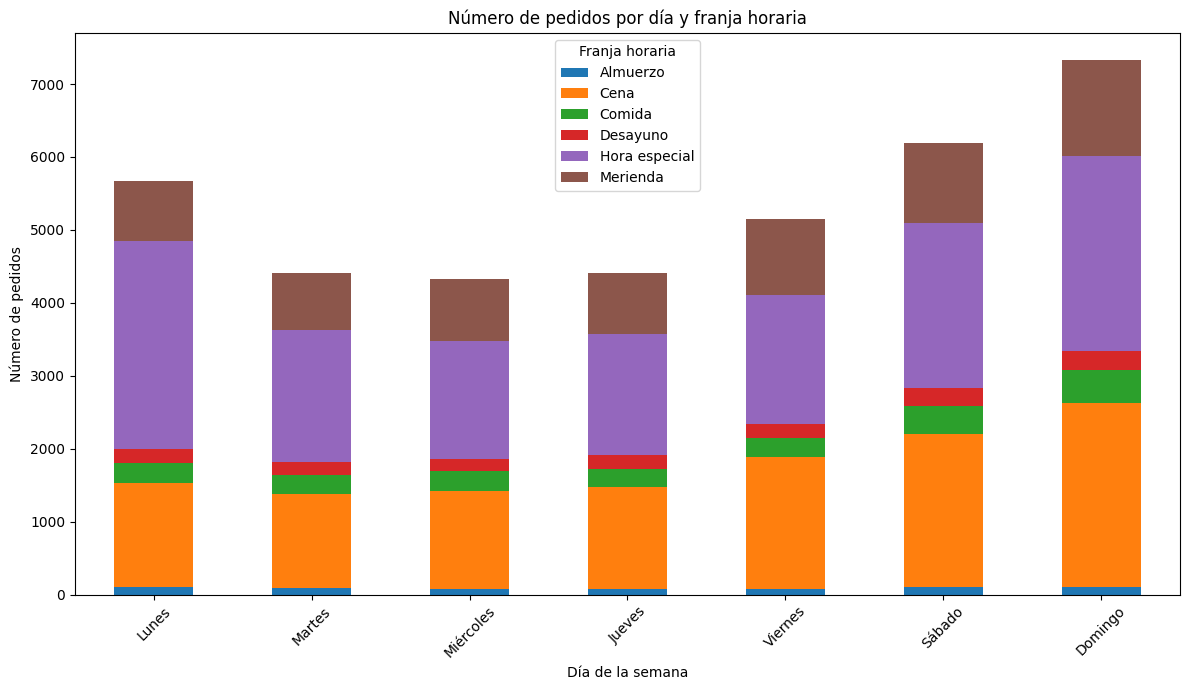

In [87]:
# Ordenar días en inglés
dias_ordenados_ingles = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
dias_ordenados_espanol = ['Lunes', 'Martes', 'Miércoles', 'Jueves', 'Viernes', 'Sábado', 'Domingo']

# Contar pedidos por día y franja horaria
tabla_pedidos = reviewsclean_df.groupby(['day_of_the_week', 'franja_horaria']).size().unstack(fill_value=0)

# Reordenar días
tabla_pedidos = tabla_pedidos.reindex(dias_ordenados_ingles)


ax = tabla_pedidos.plot(kind='bar', stacked=True, figsize=(12,7))

ax.set_xlabel('Día de la semana')
ax.set_ylabel('Número de pedidos')
ax.set_title('Número de pedidos por día y franja horaria')

plt.xticks(ticks=range(len(dias_ordenados_espanol)), labels=dias_ordenados_espanol, rotation=45)
plt.legend(title='Franja horaria')
plt.tight_layout()
plt.show()


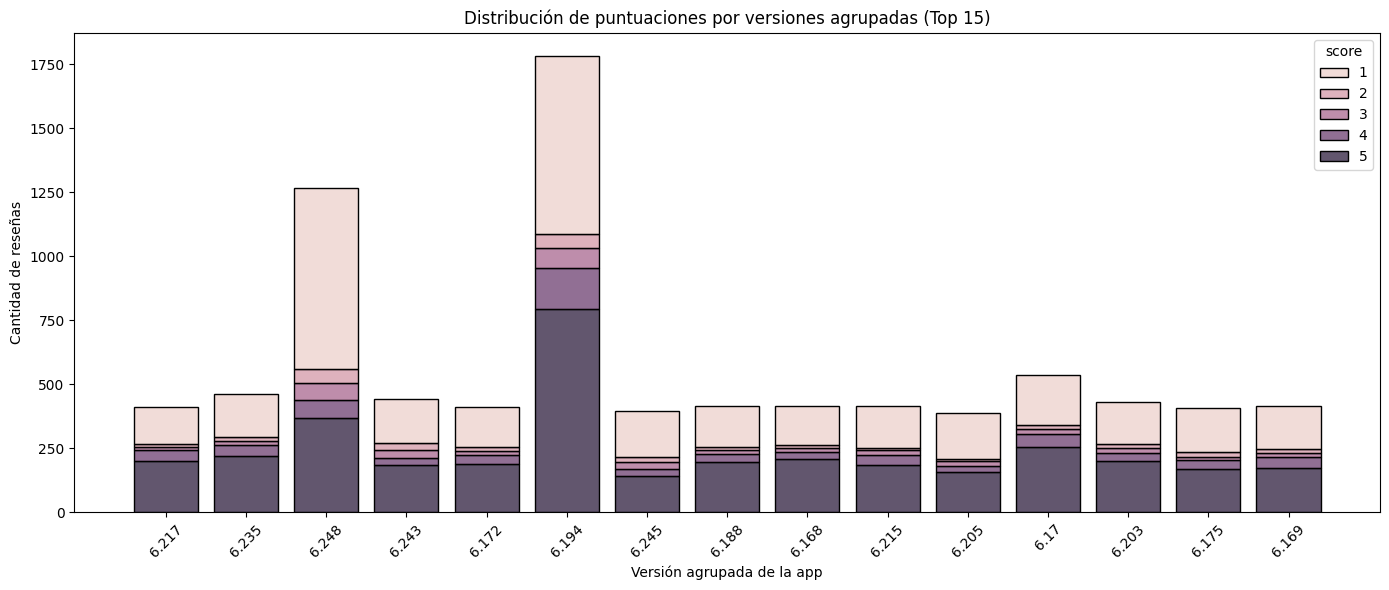

In [89]:
# Obtener las 15 versiones agrupadas más frecuentes
top_versions_grouped = reviewsclean_df['appVersion_group'].value_counts().nlargest(15).index

# Filtrar el DataFrame para solo esas versiones
filtered_df = reviewsclean_df[reviewsclean_df['appVersion_group'].isin(top_versions_grouped)].copy()
filtered_df['appVersion_group'] = filtered_df['appVersion_group'].astype(str)

plt.figure(figsize=(14, 6))
sns.histplot(
    data=filtered_df,
    x='appVersion_group',
    hue='score',
    multiple='stack',
    shrink=0.8,
    discrete=True
)

plt.title("Distribución de puntuaciones por versiones agrupadas (Top 15)")
plt.xlabel("Versión agrupada de la app")
plt.ylabel("Cantidad de reseñas")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


In [91]:

reviewsclean_df['month'] = pd.to_datetime(reviewsclean_df['at'], errors='coerce').dt.to_period('M')


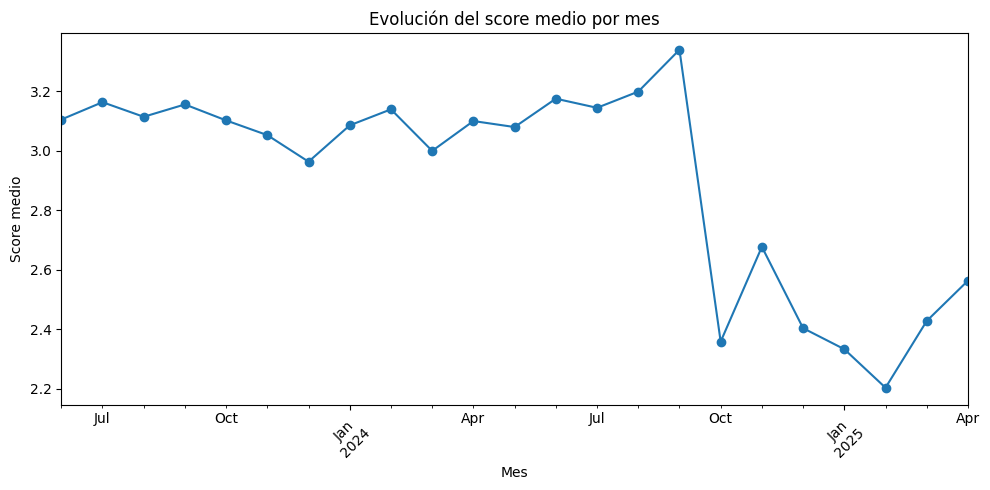

In [93]:
monthly_score = reviewsclean_df.dropna(subset=['score', 'month']).groupby('month')['score'].mean()

monthly_score.plot(kind='line', marker='o', figsize=(10, 5))
plt.title('Evolución del score medio por mes')
plt.ylabel('Score medio')
plt.xlabel('Mes')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


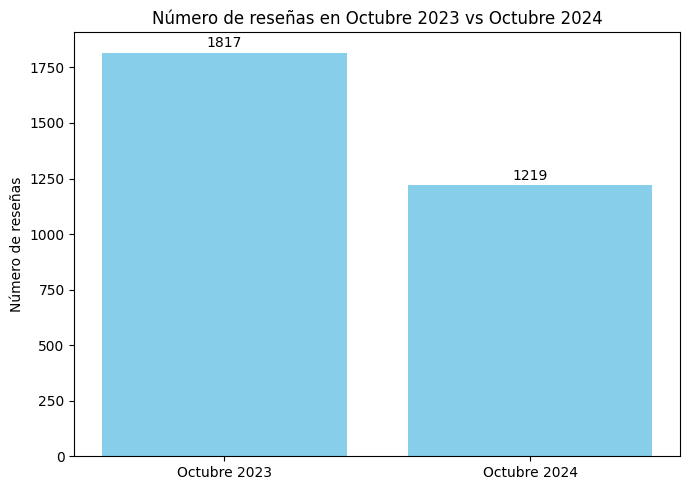

In [95]:
# Asegurar formato de fecha
reviewsclean_df['at'] = pd.to_datetime(reviewsclean_df['at'], errors='coerce')

# Crear columna de mes
reviewsclean_df['month'] = reviewsclean_df['at'].dt.to_period('M')

# Contar reseñas en octubre 2023 y octubre 2024
counts = {
    'Octubre 2023': reviewsclean_df[reviewsclean_df['month'] == '2023-10'].shape[0],
    'Octubre 2024': reviewsclean_df[reviewsclean_df['month'] == '2024-10'].shape[0]
}


plt.figure(figsize=(7, 5))
bars = plt.bar(counts.keys(), counts.values(), color='skyblue')


for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2, height + 10, str(height), ha='center', va='bottom')

plt.title("Número de reseñas en Octubre 2023 vs Octubre 2024")
plt.ylabel("Número de reseñas")
plt.tight_layout()
plt.show()



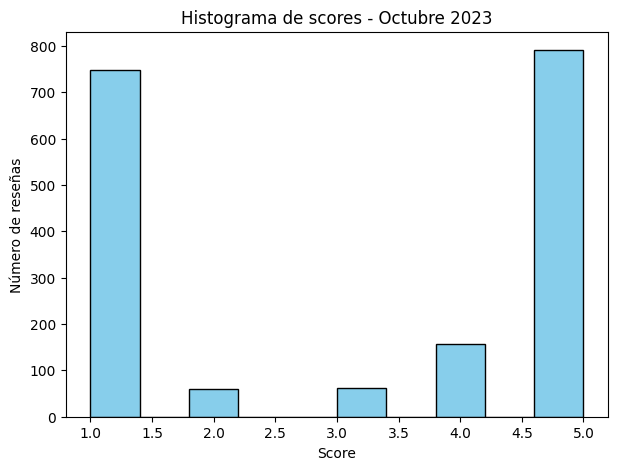

In [97]:
# Asegúrate que la columna 'at' es datetime
reviewsclean_df['at'] = pd.to_datetime(reviewsclean_df['at'], errors='coerce')

# Filtrar Octubre 2023
octubre_2023 = reviewsclean_df[(reviewsclean_df['at'].dt.year == 2023) & (reviewsclean_df['at'].dt.month == 10)]


plt.figure(figsize=(7,5))
plt.hist(octubre_2023['score'], bins=10, color='skyblue', edgecolor='black')
plt.title('Histograma de scores - Octubre 2023')
plt.xlabel('Score')
plt.ylabel('Número de reseñas')
plt.show()


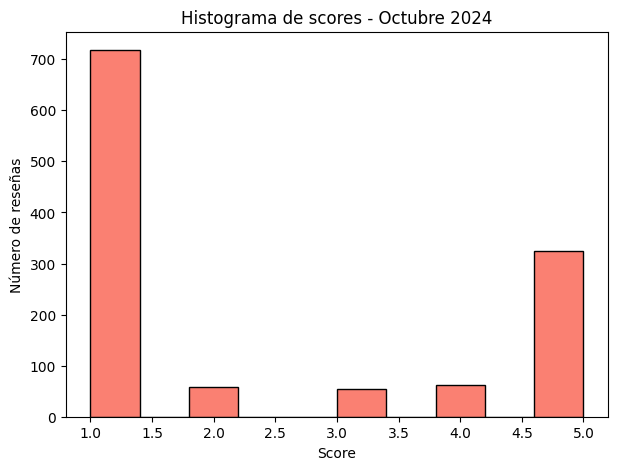

In [99]:
reviewsclean_df['at'] = pd.to_datetime(reviewsclean_df['at'], errors='coerce')

# Filtrar Octubre 2024
octubre_2024 = reviewsclean_df[(reviewsclean_df['at'].dt.year == 2024) & (reviewsclean_df['at'].dt.month == 10)]


plt.figure(figsize=(7,5))
plt.hist(octubre_2024['score'], bins=10, color='salmon', edgecolor='black')
plt.title('Histograma de scores - Octubre 2024')
plt.xlabel('Score')
plt.ylabel('Número de reseñas')
plt.show()


**MODELADO DE TÓPICOS**

In [101]:
!pip install pyldavis

In [103]:
from spacy.tokenizer import Tokenizer
from gensim.corpora import Dictionary
from gensim.models.ldamulticore import LdaMulticore
from gensim import models
from gensim.models.coherencemodel import CoherenceModel
from gensim.parsing.preprocessing import STOPWORDS as SW
import pyLDAvis
import pyLDAvis.gensim_models as gensimvis

In [105]:
import ast

# Convertir string que representa una lista a lista real
reviewsclean_df['lemmatized_review_custom'] = reviewsclean_df['lemmatized_review_custom'].apply(ast.literal_eval)


In [107]:
# Filtrar filas donde la columna no sea lista o esté vacía
reviewsclean_df = reviewsclean_df[reviewsclean_df['lemmatized_review_custom'].apply(lambda x: isinstance(x, list) and len(x) > 0)]

# Además, eliminar tokens vacíos o espacios en blanco dentro de las listas
reviewsclean_df['lemmatized_review_custom'] = reviewsclean_df['lemmatized_review_custom'].apply(lambda tokens: [t for t in tokens if t.strip() != ''])

#  crear diccionario y corpus
id2word = Dictionary(reviewsclean_df['lemmatized_review_custom'])
corpus = [id2word.doc2bow(d) for d in reviewsclean_df['lemmatized_review_custom']]


In [109]:
# Function to compute coherence values for different numbers of topics in LDA
def compute_coherence_values(dictionary, corpus, texts, limit, start, step):

    coherence_values_topic = []  # List to store coherence scores for each topic number
    model_list_topic = []  # List to store LDA models with different topic numbers

    # Iterate through different numbers of topics from 'start' to 'limit' in increments of 'step'
    for num_topics in range(start, limit, step):
        print(num_topics)  # Print the current number of topics being tested

        # Train an LDA model with the current number of topics
        model = LdaMulticore(
            corpus=corpus,        # Corpus represented in BoW or TF-IDF format
            num_topics=num_topics,  # Number of topics to generate
            id2word=id2word,      # Dictionary mapping word IDs to actual words
            passes=15,            # Number of iterations over the corpus
            random_state=15       # Set seed for reproducibility
        )

        # Append the trained model to the model list
        model_list_topic.append(model)

        # Compute coherence score for the current LDA model
        coherencemodel = CoherenceModel(
            model=model,         # The trained LDA model
            texts=texts,         # Preprocessed text data (lemmatized tokens)
            dictionary=dictionary,  # Dictionary mapping word IDs to actual terms
            coherence='c_v'      # Use 'c_v' coherence metric (common for topic models)
        )

        # Append the computed coherence score to the list
        coherence_values_topic.append(coherencemodel.get_coherence())

    return model_list_topic, coherence_values_topic

In [107]:
el_list_topic, coherence_values_topic = compute_coherence_values(dictionary=id2word,
                                                        corpus=corpus,
                                                        texts=reviewsclean_df['lemmatized_review_custom'],
                                                        start=2, limit=12, step=1) #2 topicos para empezar con un límite de 7 tópicos y el step hace referencia a que vayan de uno en uno.

2
3
4
5
6
7
8
9
10
11


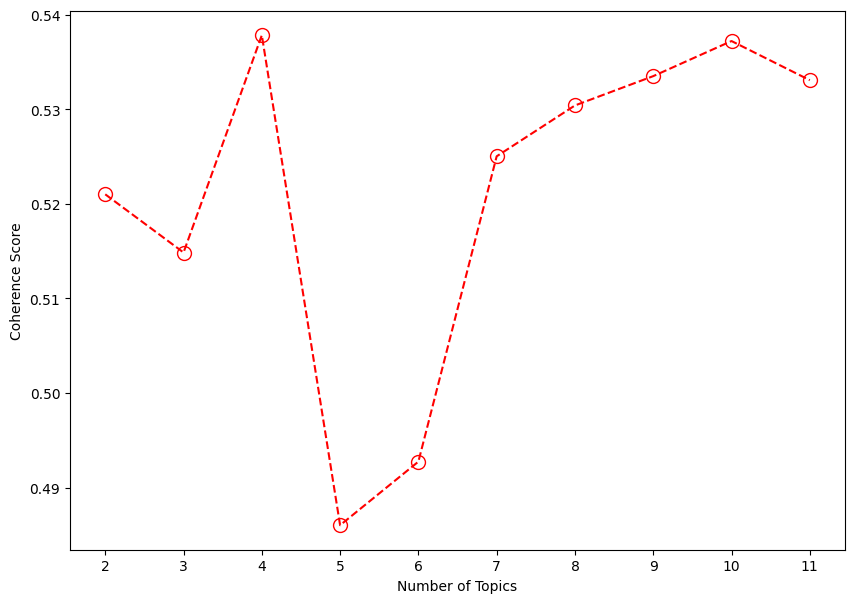

In [111]:
import matplotlib.path as mpath

plt.figure(figsize=(10,7))
plt.plot([2,3,4,5,6,7,8,9,10,11], coherence_values_topic, '--r', marker="o", markersize=10, fillstyle='none')

plt.xlabel('Number of Topics')
plt.ylabel('Coherence Score')

plt.xticks([2,3,4,5,6,7,8,9,10,11])

plt.show()


In [143]:
from gensim.models import LdaModel

model_k = LdaModel(
    corpus=corpus,
    id2word=id2word,
    num_topics=4,
    passes=15,
    random_state=45
)


In [147]:
model_k.save("lda_model_k4.model")


In [113]:
from gensim.models import LdaModel

model_k = LdaModel.load("lda_model_k4.model")


In [115]:
coherence_model_k = CoherenceModel(
    model=model_k,                   # The trained LDA model
    texts=reviewsclean_df['lemmatized_review_custom'],  # Preprocessed text data (lemmatized tokens) from the dataset
    dictionary=id2word,               # Dictionary mapping word IDs to actual terms
    coherence='c_v'                   # Type of coherence metric ('c_v' is commonly used for topic models)
)

# Calculate the coherence score
coherence_model_k = coherence_model_k.get_coherence()


print('\nCoherence Score: ', coherence_model_k)


Coherence Score:  0.5139554709885154


In [117]:
# Print the Keyword in the topics
print(model_k.print_topics())
doc_lda = model_k[corpus]
# Filtering for words
words = [re.findall(r'"([^"]*)"',t[1]) for t in model_k.print_topics()]
# Create Topics
topics = [' '.join(t[0:10]) for t in words]
# Getting the topics
for id, t in enumerate(topics):
    print(f"------ Topic {id} ------")
    print(t, end="\n\n")  #las primeras palaras tienen mas probabilidades de ser relevantes para el tópico.

[(0, '0.089*"buen" + 0.052*"servicio" + 0.038*"excelente" + 0.036*"mejor" + 0.029*"comer" + 0.025*"siempre" + 0.023*"rapido" + 0.023*"pedir" + 0.018*"tiempo" + 0.015*"opcion"'), (1, '0.051*"hora" + 0.038*"pedir" + 0.024*"esperar" + 0.023*"llegar" + 0.015*"minuto" + 0.014*"comer" + 0.013*"frio" + 0.011*"tardar" + 0.011*"tarde" + 0.009*"medio"'), (2, '0.064*"pedir" + 0.022*"cobrar" + 0.018*"pagar" + 0.017*"reparto" + 0.015*"llegar" + 0.015*"dinero" + 0.014*"poder" + 0.013*"vez" + 0.013*"servicio" + 0.012*"dar"'), (3, '0.055*"bien" + 0.033*"descuento" + 0.028*"promocion" + 0.023*"cupon" + 0.022*"precio" + 0.021*"envio" + 0.017*"funcionar" + 0.017*"gustar" + 0.015*"dar" + 0.012*"caro"')]
------ Topic 0 ------
buen servicio excelente mejor comer siempre rapido pedir tiempo opcion

------ Topic 1 ------
hora pedir esperar llegar minuto comer frio tardar tarde medio

------ Topic 2 ------
pedir cobrar pagar reparto llegar dinero poder vez servicio dar

------ Topic 3 ------
bien descuento pro

In [119]:
# Function to convert a document into LDA topic probability features
def document_to_lda_features(model_k, document):
    # Get the topic probability distribution for the given document
    topic_importance = np.array(model_k.get_document_topics(document, minimum_probability=0))
    # - model_k.get_document_topics(document) returns a list of (topic_id, probability) pairs.
    # - minimum_probability=0 ensures all topics are included (even if the probability is very low).
    # - The output is converted into a NumPy array for easier manipulation.

    # Extract only the probability values (second column of the array)
    return topic_importance[:, 1]
    # - topic_importance[:, 1] selects the second column (probabilities) for each topic.
    # - The function returns an array where each element represents the probability of a topic in the document.

# Apply the function to all documents in the corpus and store results in a new DataFrame column
reviewsclean_df['lda_features'] = list(map(lambda doc: document_to_lda_features(model_k, doc), corpus))
# - map() applies `document_to_lda_features(model_k, doc)` to each document in `corpus`.
# - list() converts the result into a list, where each document gets an array of topic probabilities.
# - The extracted LDA topic features are stored in a new column `df['lda_features']`.

In [120]:
reviewsclean_df

,content,score,at,appVersion,normalized_review,tokenized_review,no_stopwords_review,lemmatized_review,lemmatized_review_custom,day_of_the_week,hora,franja_horaria,appVersion_group,review_length,month,lda_features
0,"no acepta tarjetas prepago además te cobran 0,...",1,2025-04-15 11:54:08,6.265.10001,no acepta tarjetas prepago ademas te cobran p...,"['no', 'acepta', 'tarjetas', 'prepago', 'adema...","['acepta', 'tarjetas', 'prepago', 'ademas', 'c...","['aceptar', 'tarjeta', 'prepago', 'adema', 'co...","[aceptar, tarjeta, prepago, cobrar, comprobar,...",Tuesday,11,Almuerzo,6.265,115,2025-04,"[0.022757157683372498, 0.022756945341825485, 0..."
1,inflan muchisimos los precios te cobran el env...,1,2025-04-15 09:08:41,6.265.10001,inflan muchisimos los precios te cobran el env...,"['inflan', 'muchisimos', 'los', 'precios', 'te...","['inflan', 'muchisimos', 'precios', 'cobran', ...","['inflar', 'muchisir', 'precio', 'cobrar', 'en...","[inflar, muchisir, precio, cobrar, envio, gast...",Tuesday,9,Desayuno,6.265,179,2025-04,"[0.013987978920340538, 0.12615123391151428, 0...."
2,era buena cuando daban cupones buenos habían p...,1,2025-04-15 07:46:26,6.266.10000,era buena cuando daban cupones buenos habian p...,"['era', 'buena', 'cuando', 'daban', 'cupones',...","['buena', 'daban', 'cupones', 'buenos', 'habia...","['buen', 'dar', 'cupón', 'buen', 'habiar', 'pr...","[buen, dar, cupon, buen, habiar, precio, bajo,...",Tuesday,7,Desayuno,6.266,268,2025-04,"[0.28422921895980835, 0.012099658139050007, 0...."
3,kiero. explorarla,5,2025-04-15 06:52:18,6.265.10001,kiero explorarla,"['kiero', 'explorarla']","['kiero', 'explorarla']","['kiero', 'explorar él']","[kiero, explorar]",Tuesday,6,Hora especial,6.265,17,2025-04,"[0.08402914553880692, 0.0840645506978035, 0.08..."
4,me estuve comunicando con un repartidor sobre ...,1,2025-04-15 06:01:49,6.265.10001,me estuve comunicando con un repartidor sobre ...,"['me', 'estuve', 'comunicando', 'con', 'un', '...","['comunicando', 'repartidor', 'problema', 'cam...","['comunicar', 'repartidor', 'problema', 'cambi...","[comunicar, reparto, problema, cambiar, direcc...",Tuesday,6,Hora especial,6.265,373,2025-04,"[0.04912049323320389, 0.05077363923192024, 0.8..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
37494,Rateros!!!! Eso es lo que son unos rateros¡ Te...,1,2023-06-15 22:27:21,6.149.10002,rateros eso es lo que son unos rateros te cobr...,"['rateros', 'eso', 'es', 'lo', 'que', 'son', '...","['rateros', 'rateros', 'cobran', 'ponen', 'pro...","['ratero', 'ratero', 'cobrar', 'poner', 'promo...","[ratero, ratero, cobrar, poner, promocion, res...",Thursday,22,Cena,6.149,293,2023-06,"[0.013420968316495419, 0.07500020414590836, 0...."
37495,Muy buena aplicación y cuando tienes un proble...,5,2023-06-15 22:07:04,6.168.10003,muy buena aplicacion y cuando tienes un proble...,"['muy', 'buena', 'aplicacion', 'y', 'cuando', ...","['buena', 'problema', 'enseguida', 'resuelven']","['buen', 'problema', 'enseguida', 'resolver']","[buen, problema, enseguida, resolver]",Thursday,22,Cena,6.168,74,2023-06,"[0.3921135365962982, 0.0500335656106472, 0.507..."
37496,Tengo un problema para cancelar la suscripción...,1,2023-06-15 22:00:21,6.168.10003,tengo un problema para cancelar la suscripcion...,"['tengo', 'un', 'problema', 'para', 'cancelar'...","['problema', 'cancelar', 'suscripcion', 'apare...","['problema', 'cancelar', 'suscripcion', 'apare...","[problema, cancelar, suscripcion, aparecer, op...",Thursday,22,Cena,6.168,221,2023-06,"[0.014165539294481277, 0.013967204838991165, 0..."
37497,Me fue util muy poco y luego me robaron dinero...,1,2023-06-15 21:52:06,6.167.10003,me fue util muy poco y luego me robaron dinero...,"['me', 'fue', 'util', 'muy', 'poco', 'y', 'lue...","['util', 'luego', 'robaron', 'dinero', 'restau...","['util', 'luego', 'robar', 'dinero', 'restaura...","[util, luego, robar, dinero, restaurandte, can...",Thursday,21,Cena,6.167,452,2023-06,"[0.006669310387223959, 0.03127551078796387, 0..

In [123]:
pd.set_option('display.max_colwidth', None)
print(reviewsclean_df['lda_features'])


0          [0.022757157683372498, 0.022756945341825485, 0.840614914894104, 0.11387095600366592]
1          [0.013987978920340538, 0.12615123391151428, 0.34897541999816895, 0.5108854174613953]
2          [0.28422921895980835, 0.012099658139050007, 0.39359524846076965, 0.3100758492946625]
3            [0.08402914553880692, 0.0840645506978035, 0.08397837728261948, 0.7479279637336731]
4          [0.04912049323320389, 0.05077363923192024, 0.8904047608375549, 0.009701062925159931]
                                                  ...                                          
37494       [0.013420968316495419, 0.07500020414590836, 0.6471554636955261, 0.2644234001636505]
37495         [0.3921135365962982, 0.0500335656106472, 0.5078192353248596, 0.05003363639116287]
37496    [0.014165539294481277, 0.013967204838991165, 0.9577314853668213, 0.014135777950286865]
37497      [0.006669310387223959, 0.03127551078796387, 0.9245713353157043, 0.03748386725783348]
37498       [0.11000723391771317, 0.1719

In [125]:
# Function to identify the most important topic for each document
def topic_important(item_score):
    score = np.argmax(item_score, axis=0)  # Find the topic with the highest probability score
    return score

reviewsclean_df['topic_dominant'] = reviewsclean_df['lda_features'].apply(topic_important)

In [129]:
reviewsclean_df

,content,score,at,appVersion,normalized_review,tokenized_review,no_stopwords_review,lemmatized_review,lemmatized_review_custom,day_of_the_week,hora,franja_horaria,appVersion_group,review_length,month,lda_features,topic_dominant
0,"no acepta tarjetas prepago además te cobran 0,63 para comprobar si tu tarjeta es válida e imposible eliminar cuenta",1,2025-04-15 11:54:08,6.265.10001,no acepta tarjetas prepago ademas te cobran para comprobar si tu tarjeta es valida e imposible eliminar cuenta,"['no', 'acepta', 'tarjetas', 'prepago', 'ademas', 'te', 'cobran', 'para', 'comprobar', 'si', 'tu', 'tarjeta', 'es', 'valida', 'e', 'imposible', 'eliminar', 'cuenta']","['acepta', 'tarjetas', 'prepago', 'ademas', 'cobran', 'comprobar', 'tarjeta', 'valida', 'imposible', 'eliminar', 'cuenta']","['aceptar', 'tarjeta', 'prepago', 'adema', 'cobrar', 'comprobar', 'tarjeta', 'valido', 'imposible', 'eliminar', 'cuenta']","[aceptar, tarjeta, prepago, cobrar, comprobar, tarjeta, valido, imposible, eliminar, cuenta]",Tuesday,11,Almuerzo,6.265,115,2025-04,"[0.022757157683372498, 0.022756945341825485, 0.840614914894104, 0.11387095600366592]",2
1,"inflan muchisimos los precios te cobran el envio y los gastos de gestion mas caro que el propio pedido tarda en llegar llega todl siempre frio,roto o ni llega y no te dan solucion",1,2025-04-15 09:08:41,6.265.10001,inflan muchisimos los precios te cobran el envio y los gastos de gestion mas caro que el propio pedido tarda en llegar llega todl siempre frioroto o ni llega y no te dan solucion,"['inflan', 'muchisimos', 'los', 'precios', 'te', 'cobran', 'el', 'envio', 'y', 'los', 'gastos', 'de', 'gestion', 'mas', 'caro', 'que', 'el', 'propio', 'pedido', 'tarda', 'en', 'llegar', 'llega', 'todl', 'siempre', 'frioroto', 'o', 'ni', 'llega', 'y', 'no', 'te', 'dan', 'solucion']","['inflan', 'muchisimos', 'precios', 'cobran', 'envio', 'gastos', 'gestion', 'caro', 'propio', 'pedido', 'tarda', 'llegar', 'llega', 'todl', 'siempre', 'frioroto', 'llega', 'dan', 'solucion']","['inflar', 'muchisir', 'precio', 'cobrar', 'envio', 'gasto', 'gestion', 'caro', 'propio', 'pedido', 'tardar', 'llegar', 'llegar', 'todl', 'siempre', 'frioroto', 'llegar', 'dar', 'solucion']","[inflar, muchisir, precio, cobrar, envio, gasto, gestion, caro, propio, pedir, tardar, llegar, llegar, todl, siempre, frioroto, llegar, dar, solucion]",Tuesday,9,Desayuno,6.265,179,2025-04,"[0.013987978920340538, 0.12615123391151428, 0.34897541999816895, 0.5108854174613953]",3
2,era buena cuando daban cupones buenos habían precios bajos te daban Uber cash 300 pero ahora ya no es como antes es la peor aplicación todavía es mejor didi aún que no de tantos cupones pero los repartidores son amigables y en rappi es la mejor pero Uber eats no sirve,1,2025-04-15 07:46:26,6.266.10000,era buena cuando daban cupones buenos habian precios bajos te daban uber cash pero ahora ya no es como antes es la peor aplicacion todavia es mejor didi aun que no de tantos cupones pero los repartidores son amigables y en rappi es la mejor pero uber eats no sirve,"['era', 'buena', 'cuando', 'daban', 'cupones', 'buenos', 'habian', 'precios', 'bajos', 'te', 'daban', 'uber', 'cash', 'pero', 'ahora', 'ya', 'no', 'es', 'como', 'antes', 'es', 'la', 'peor', 'aplicacion', 'todavia', 'es', 'mejor', 'didi', 'aun', 'que', 'no', 'de', 'tantos', 'cupones', 'pero', 'los', 'repartidores', 'son', 'amigables', 'y', 'en', 'rappi', 'es', 'la', 'mejor', 'pero', 'uber', 'eats', 'no', 'sirve']","['buena', 'daban', 'cupones', 'buenos', 'habian', 'precios', 'bajos', 'daban', 'cash', 'ahora', 'peor', 'todavia', 'mejor', 'didi', 'tantos', 'cupones', 'repartidores', 'amigables', 'rappi', 'mejor', 'sirve']","['buen', 'dar', 'cupón', 'buen', 'habiar', 'precio', 'bajo', 'dar', 'cash', 'ahora', 'peor', 'todavia', 'mejor', 'didi', 'tanto', 'cupón', 'repartidor', 'amigabl', 'rappi', 'mejor', 'servir']","[buen, dar, cupon, buen, habiar, precio, bajo, dar, cash, ahora, peor, todavia, mejor, didi, cupon, reparto, amigabl, rappi, mejo

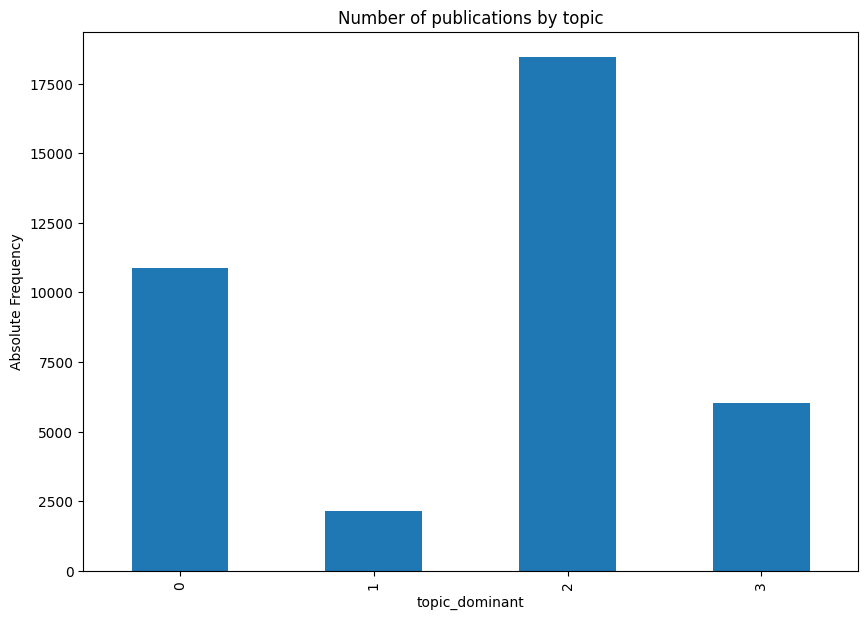

In [131]:
plt.figure(figsize=(10,7))
ax=reviewsclean_df["topic_dominant"].value_counts().sort_index().plot(kind='bar')
plt.ylabel('Absolute Frequency')
plt.title('Number of publications by topic')
plt.show()

In [133]:
pyLDAvis.enable_notebook()

vis = gensimvis.prepare(model_k, corpus, id2word)

vis

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
2     -0.061117 -0.107437       1        1  58.829498
0      0.001477 -0.226222       2        1  15.697019
1     -0.242987  0.196487       3        1  12.973012
3      0.302627  0.137171       4        1  12.500471, topic_info=          Term         Freq        Total Category  logprob  loglift
28        buen  5338.000000  5338.000000  Default  30.0000  30.0000
84    servicio  6135.000000  6135.000000  Default  29.0000  29.0000
69        bien  2628.000000  2628.000000  Default  28.0000  28.0000
129       hora  2520.000000  2520.000000  Default  27.0000  27.0000
206  excelente  2309.000000  2309.000000  Default  26.0000  26.0000
..         ...          ...          ...      ...      ...      ...
95       poder   402.755266  3699.733521   Topic4  -4.7773  -0.1383
83       salir   284.807439   979.337779   Topic4  -5.1238   0.8443
72       deber   261.741424   942.564282   Topic4  -5.2083   0.7982
386     compra   249.025810   596.074481   Topic4  -5.2581   1.2066
214       usar   256.300185  1613.241460   Topic4  -5.2293   0.2398

[226 rows x 6 columns], token_table=      Topic      Freq      Term
term                           
25        1  0.631932     ahora
25        4  0.368147     ahora
1208      2  0.998105  alimento
642       4  0.996737      alto
755       2  0.997234    amable
...     ...       ...       ...
141       3  0.062555       vez
141       4  0.066796       vez
553       1  0.997888    volver
553       3  0.001526    volver
2186      2  0.992165      zona

[251 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[3, 1, 2, 4])

In [135]:
# Convertir la lista de tokens a texto para cada fila (bigramas se calculan sobre texto)
reviewsclean_df['text_for_tfidf'] = reviewsclean_df['lemmatized_review_custom'].apply(lambda tokens: ' '.join(tokens))

# Crear una lista para almacenar resultados
top_bigrams_per_topic = {}

for topic in sorted(reviewsclean_df['topic_dominant'].unique()):
    # Filtrar reviews para el tópico actual
    texts_topic = reviewsclean_df[reviewsclean_df['topic_dominant'] == topic]['text_for_tfidf'].tolist()

    # Vectorizador TF-IDF para bigramas
    vectorizer = TfidfVectorizer(ngram_range=(2, 2), max_features=20)  # top 20 bigramas

    # Ajustar y transformar
    X = vectorizer.fit_transform(texts_topic)

    # Obtener términos y sus TF-IDF medios
    tfidf_scores = X.mean(axis=0).A1  # media en todas las reviews del tópico
    terms = vectorizer.get_feature_names_out()

    # Crear DataFrame para ordenar y mostrar bigramas
    df_tfidf = pd.DataFrame({'bigram': terms, 'score': tfidf_scores})
    df_tfidf = df_tfidf.sort_values(by='score', ascending=False).reset_index(drop=True)

    print(f"\nTop bigramas para tópico {topic}:\n", df_tfidf)
    top_bigrams_per_topic[topic] = df_tfidf




Top bigramas para tópico 0:
                 bigram     score
0        buen servicio  0.055010
1   excelente servicio  0.045715
2           facil usar  0.024923
3       buen promocion  0.024155
4          pedir comer  0.022275
5          buen opcion  0.016844
6     buen experiencia  0.014791
7          buen oferta  0.011764
8          mejor pedir  0.010042
9           salir casa  0.009818
10     servicio rapido  0.009341
11      siempre llegar  0.009249
12      buen descuento  0.008896
13          buen pedir  0.007927
14         sacar apuro  0.007767
15     comer domicilio  0.007522
16       llegar tiempo  0.007508
17       buen atencion  0.007031
18           buen buen  0.006737
19    atencion cliente  0.006490

Top bigramas para tópico 1:
                bigram     score
0        pedir llegar  0.027245
1         llegar frio  0.027006
2          hora medio  0.022136
3        hora esperar  0.021568
4          comer frio  0.017232
5       esperar pedir  0.016728
6         tardar hora  

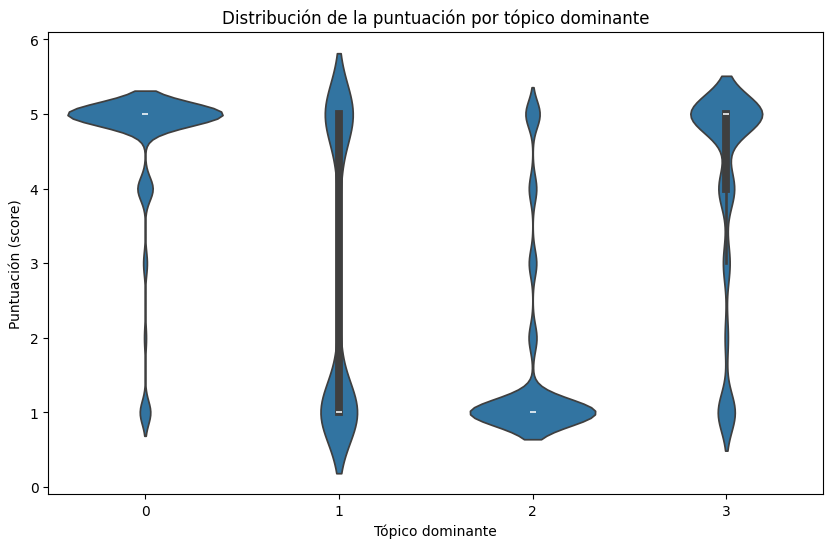

In [136]:
plt.figure(figsize=(10,6))
sns.violinplot(data=reviewsclean_df, x='topic_dominant', y='score')
plt.title('Distribución de la puntuación por tópico dominante')
plt.xlabel('Tópico dominante')
plt.ylabel('Puntuación (score)')
plt.show()


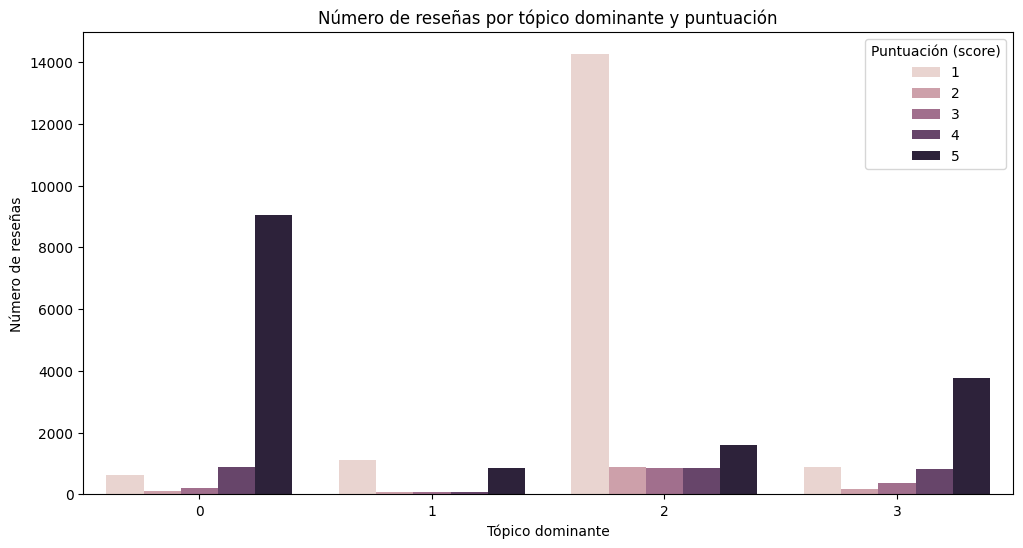

In [138]:
plt.figure(figsize=(12,6))

sns.countplot(data=reviewsclean_df, x='topic_dominant', hue='score')

plt.title('Número de reseñas por tópico dominante y puntuación')
plt.xlabel('Tópico dominante')
plt.ylabel('Número de reseñas')
plt.legend(title='Puntuación (score)')
plt.show()
